<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/5_second_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


In [2]:
data_1 = pd.read_csv("full_final_df.csv")

In [3]:
data_1

,גוף המסמך,מספר תיק,Outcome of case,outcome_category
0,"['פסק דין בתיק ע""פ 9917/02 בבית המשפט העליון ב...",9917/02,O R,1
1,"['פסק-דין בתיק ע""פ 845/02 בבית המשפט העליון בש...",845/02,O R,1
2,"['פסק-דין בתיק ע""פ 4379/02 בבית המשפט העליון ב...",4379/02,O A,0
3,"['פסק דין בתיק ע""פ 9059/03 בבית המשפט העליון ב...",9059/03,O A,0
4,"['פסק-דין בתיק ע""פ 7075/03 בבית המשפט העליון ב...",7075/03,O A,0
...,...,...,...,...
1058,"['פסק דין בתיק רע""פ 7446/07 בבית המשפט העליון ...",7446/07,G A,0
1059,"['החלטה בתיק רע""פ 3248/07 בבית המשפט העליון רע...",3248/07,G V RETURN TO COURT with appellee's consent,2
1060,"['פסק דין בתיק ע""פ 5570/01 בבית המשפט העליון ב...",5570/01,O R RETURN TO COURT,2
1061,"['פסק דין בתיק ע""פ 7450/01 בבית המשפט העליון ב...",7450/01,O A,0


In [4]:
data_1["Outcome of case"].unique()

array(['O R', 'O A', 'O RETURN TO COURT',
       'O Approved in part + Denied in part', 'G R',
       'O COMPROMISE VERDICT', 'O R RETURN TO COURT', 'O WITHDRAWAL',
       'O approved in part + denied in part', 'O R COMPROMISE VERDICT',
       'G A',
       'G R substential matter that was resolved with no consequences on the defendant (as the state consented)',
       'G V (vacated in part)', 'O V', 'O R A',
       "G A at most- defendant was acquitted of one felony with plaintiff's consent. The sunction remained.",
       'Crim + Sent A G', 'G', 'G RETURN TO COURT',
       "G WITHDRAWAL V Appellant was aquitted of one felony with appellee's consent. The rest of the appeal was withdrawaled.",
       'O A WITHDRAWAL',
       'O V denied in part, merged with another procedure in part.',
       'Crim + Sub G R', 'Crim + Sent V Erased (became irrelevant)',
       "Crim + Pro V Erased due to the fact that the procedures un the Magistrates Court wasn't finished",
       'G R RETURN TO COURT

In [5]:
data_1["Type"] = data_1["Outcome of case"].apply(lambda x: 1 if 'G' in x else 0)

In [6]:
data_1["outcome_category"].unique()

array([1, 0, 2])

In [7]:
data= data_1[data_1["outcome_category"]!=2] # Drop others

In [8]:
data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)

<ipython-input-8-8cca5b4870b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)


In [9]:
# הדפסת הערכים הייחודיים של "Outcome of case" לפי הערכים בעמודת "Type"
unique_values_by_type = data.groupby("Type")["Outcome of case"].unique()

# הדפסת הערכים הייחודיים לכל Type
for type_value, unique_values in unique_values_by_type.items():
    print(f"Type {type_value}:")
    for value in unique_values:
        print(value)
    print("=" * 80)

Type 0:
O R
O A
Type 1:
G R
G A
G A at most- defendant was acquitted of one felony with plaintiff's consent. The sunction remained.
Crim + Sent A G
Crim + Sub G R
G R RETURN TO COURT
G A with apellee's consent



## Training

In [10]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [12]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק ע"פ 4379/02 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7075/03 בב
ית המשפט העליון בש...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['504 G
ateway Time-out 504 Gateway Time-out ngi...
['פסק-דין בתיק ע"פ 4654/03 בבית המשפ
ט העליון ע"...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['{ "status": 
"Failure", "status_code": 400, "c...
['פסק-דין בתיק ע"פ 10360/03 בבית המשפט העלי
ון ב...
['פסק-דין בתיק ע"פ 10596/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 10
996/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 9216/03 בבית המשפט העליון בש...

['{ "status": "Failure", "status_code": 422, "c...
['פסק-דין בתיק ע"פ 3948/03 ב
בית המשפט העליון בש...
['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק 
דין בתיק ע"פ 2132/04 בבית המשפט העליון בש...
['{ "status": "Failure", "status_co
de": 422, "c...
['פסק-דין בתיק ע"פ 10800/04 בבית המשפט העליון ב...
['פסק-דין בתי
ק ע"פ 2597/04 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7895/04 בבית המשפט העלי

binary_outcome
0    704
1    210
Name: count, dtype: int64


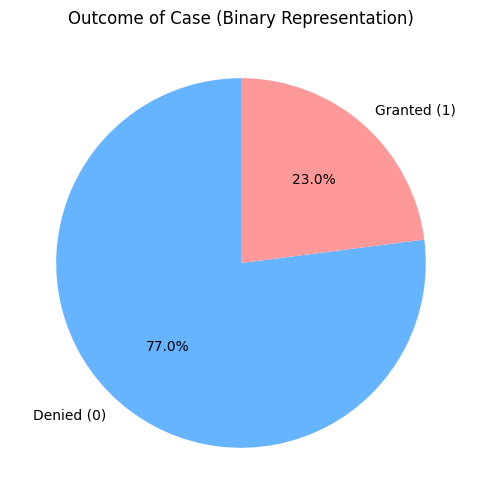

In [13]:
def pie_labels(data):
  binary_counts = data['binary_outcome'].value_counts()
  print(binary_counts)
  labels = ['Denied (0)','Granted (1)']

  plt.figure(figsize=(6, 6))
  plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
  plt.title('Outcome of Case (Binary Representation)')

  plt.show()


pie_labels(data)

In [35]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text





In [36]:
data_dca = data[data["Type"]==1]
data_ca = data[data["Type"]==0]

## Data CA


In [37]:
# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data_ca = data_ca.dropna(subset=["גוף המסמך", "outcome_category"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data_ca["גוף המסמך"] = data_ca["גוף המסמך"].apply(lambda x: trim_text(x, 500, 95))

Streaming output truncated to the last 5000 lines.
רער (המאסר בתיק זה, המאסר על-תנאי המופעל והעונש שנגזר לאחרונה בבית משפט השלום) ת
עמוד על 48 חודשים. יתר חלקי גזר דינו של בית המשפט המחוזי, יעמדו בעינם. ניתן היום
, י"א בסיוון התשס"ז (28.05.07). ש ו פ ט ש ו פ ט ש ו פ ט ________________________
_ העותק כפוף לשינויי
##*******************************************************####
Trimmed Text (Original Length: 6675, Trimmed Length: 500):
 בחופף לעונש המאסר שנגזר בתיק זה, ופיצוי למתלונן בסך 10,000 ש"ח. על המערער 2 הוט
לו שלוש שנות מאסר בפועל, מאסר על תנאי, פיצוי למתלונן בסך 10,000 ש"ח ושלוש שנות פ
סילה. המערערים טענו נגד חומרת העונש. לא מצאנו מקום להתערב בנושא העונש לא לכאן ול
א לכאן. העונש נוטה לדעתנו לקולא בשים לב לאלימות שהופעלה, אך לא במידה המצדיקה את 
התערבותנו. 9. סוף דבר: ערעורם של המערערים וערעורה של המדינה נדחים. ניתן היום, ג\
' בשבט תשס"ז (22.1.2007). ש ו פ ט ת ש ו פ ט ת ש ו פ ט ת ________________________
_ העותק כפוף לשינויי
##*******************************************************

In [ ]:
# pie_labels(data_dca)

binary_outcome
0    683
1    201
Name: count, dtype: int64


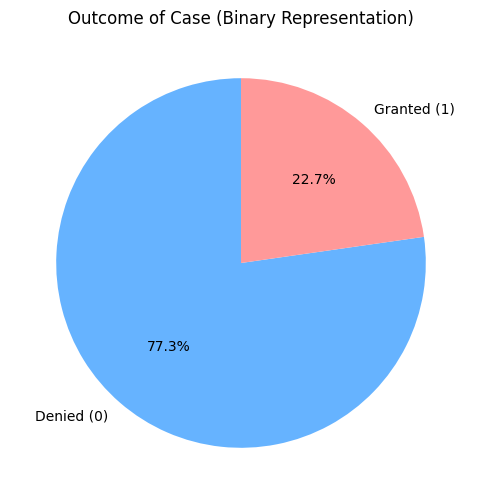

In [39]:
pie_labels(data_ca)

In [40]:
def train_models(data):
    # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
    y_ = data["binary_outcome"].values
    embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])

    # יצירת פיצ'ר TYPE כוקטור נפרד
    type_feature = data["Type"].values.reshape(-1, 1)

    # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
    undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

    # שילוב האימבדינג והפיצ'ר TYPE
    X = np.hstack((embeddings, type_feature))
    X_resampled, y_resampled = undersampler.fit_resample(X, y_)

    # שמירת אינדקסים מקוריים
    resampled_indices = undersampler.sample_indices_

    # בדיקת תקינות האינדקסים
    valid_indices = [i for i in resampled_indices if i < len(data)]
    if len(valid_indices) < len(resampled_indices):
        print(f"Warning: {len(resampled_indices) - len(valid_indices)} indices are out of bounds and will be removed.")

    resampled_indices = valid_indices
    joblib.dump(resampled_indices, 'second_resampled_indices.pkl')

    # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
    binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
    if not np.array_equal(y_resampled[:len(resampled_indices)], binary_outcome_resampled):
        raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

    # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

    # התאמת המודל לנתונים המאוזנים
    classifier.fit(X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)])

    # הגדרת מדדים לקרוס ולידציה
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, pos_label=1),
        'recall': make_scorer(recall_score, pos_label=1),
        'f1': make_scorer(f1_score, pos_label=1)
    }

    # ביצוע Cross Validation
    cv_results = cross_validate(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, scoring=scoring)

    # חיזוי תוויות והסתברויות על כל קפל לצורך קונפיושן מטריקס והסתברויות
    y_pred = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5)
    y_prob = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, method='predict_proba')[:, 1]  # הסתברות לקלאס 1
    conf_matrix = confusion_matrix(y_resampled[:len(resampled_indices)], y_pred)

    # הדפסת התוצאות
    print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
    print("Mean Accuracy:", cv_results['test_accuracy'].mean())
    print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
    print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
    print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
    print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
    print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
    print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

    tn, fp, fn, tp = conf_matrix.ravel()

    # הדפסת הקונפיושן מטריקס עם תוויות
    print("Confusion Matrix with Labels:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    print("\nConfusion Matrix:")
    print(f"[[{tn} {fp}]")
    print(f" [{fn} {tp}]]")

    # שמירת האינדקסים המקוריים של הדגימות המסומפלות
    original_indices = data.index[resampled_indices]

    # הוספת עמודת הסתברויות
    data['predicted_probabilities'] = np.nan
    data.loc[original_indices, 'predicted_probabilities'] = y_prob

    # שמירת המודל והמשאבים
    joblib.dump(classifier, 'second_classifier_model.pkl')
    data.to_csv('updated_data_with_probabilities_2.csv', index=False)

    print("המודל, התוצאות והנתונים נשמרו בהצלחה.")

    return data,classifier,X_resampled,y_resampled, resampled_indices


In [ ]:
data_ca, classifier_ca, X_ca_resampled,y_ca_resampled, resampled_ca_indices = train_models(data_ca)

In [ ]:
# # בדיקה שהעמודה 'predicted_probabilities' קיימת ואינה ריקה
# if 'predicted_probabilities' not in data.columns or data['predicted_probabilities'].isna().all():
#     raise ValueError("Column 'predicted_probabilities' is missing or contains only NaN values!")

# # חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור כל קלאס
# for cls in data['binary_outcome'].unique():
#     class_data = data[data['binary_outcome'] == cls]['predicted_probabilities']
#     avg_prob = class_data.mean()
#     min_prob = class_data.min()
#     max_prob = class_data.max()

#     print(f"Class {cls}:")
#     print(f"  Average Probability: {avg_prob:.4f}")
#     print(f"  Minimum Probability: {min_prob:.4f}")
#     print(f"  Maximum Probability: {max_prob:.4f}\n")


In [ ]:
# # בדיקה שהעמודה 'predicted_probabilities' קיימת ואינה ריקה
# if 'predicted_probabilities' not in data.columns or data['predicted_probabilities'].isna().all():
#     raise ValueError("Column 'predicted_probabilities' is missing or contains only NaN values!")

# # יצירת עמודת 'predicted_label' מתוך ההסתברויות (טרשהולד ברירת מחדל: 0.5)
# threshold = 0.5  # ניתן לשנות את הטרשהולד לפי הצורך
# data['predicted_label'] = (data['predicted_probabilities'] >= threshold).astype(int)

# # איתור ה-FN וה-FP
# fn_indices = data[(data['binary_outcome'] == 1) & (data['predicted_label'] == 0)].index
# fp_indices = data[(data['binary_outcome'] == 0) & (data['predicted_label'] == 1)].index

# # חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור FN
# if not fn_indices.empty:
#     fn_probs = data.loc[fn_indices, 'predicted_probabilities']
#     avg_fn_prob = fn_probs.mean()
#     min_fn_prob = fn_probs.min()
#     max_fn_prob = fn_probs.max()

#     print("False Negatives (FN):")
#     print(f"  Average Probability: {avg_fn_prob:.4f}")
#     print(f"  Minimum Probability: {min_fn_prob:.4f}")
#     print(f"  Maximum Probability: {max_fn_prob:.4f}\n")
# else:
#     print("No False Negatives (FN) found.\n")

# # חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור FP
# if not fp_indices.empty:
#     fp_probs = data.loc[fp_indices, 'predicted_probabilities']
#     avg_fp_prob = fp_probs.mean()
#     min_fp_prob = fp_probs.min()
#     max_fp_prob = fp_probs.max()

#     print("False Positives (FP):")
#     print(f"  Average Probability: {avg_fp_prob:.4f}")
#     print(f"  Minimum Probability: {min_fp_prob:.4f}")
#     print(f"  Maximum Probability: {max_fp_prob:.4f}\n")
# else:
#     print("No False Positives (FP) found.\n")


In [ ]:
def print_FN(data, classifier, X_resampled, y_resampled, resampled_indices):
    # חיזוי תוויות על כל קפל לצורך זיהוי FN
    y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

    # חיזוי הסתברויות
    y_prob = cross_val_predict(classifier, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]

    # איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
    fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

    # ודא ש-resampled_indices הוא numpy array
    resampled_indices = np.array(resampled_indices)

    # מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
    original_fn_indices = resampled_indices[fn_indices]

    # קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", "Predicted" ו-"Probability" עבור הדוגמאות שמזוהות כ-FN
    false_negative_rows = data.iloc[original_fn_indices]
    false_negative_probabilities = y_prob[fn_indices]  # ההסתברויות של המודל עבור FN
    false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

    # ווידוא סינכרון מוחלט של האינדקסים
    if len(false_negative_rows) != len(false_negative_predicted):
        raise ValueError("Mismatch between FN rows and predicted labels!")

    # הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים, התחזית, וההסתברות
    print("False Negative Cases (True Label: 1, Predicted Label: 0):")
    print("=" * 80)

    for i, (index, row, predicted, probability) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted, false_negative_probabilities), 1):
        _, row_data = row
        print(f"\nCase {i}:")
        print("-" * 80)
        print("Index in Original Data:")
        print(index)
        print("\nOriginal Outcome of Case:")
        print(row_data["Outcome of case"])
        print("\nBinary Outcome (True Label):")
        print(row_data["binary_outcome"])
        print("\nPredicted Label:")
        print(predicted)
        print("\nPredicted Probability:")
        print(f"{probability:.4f}")
        print("\nDocument Body:")
        formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
        print(formatted_text)
        print("-" * 80)

    print("=" * 80)


In [ ]:
print_FN(data_ca,classifier_ca,X_ca_resampled,y_ca_resampled, resampled_ca_indices)

In [ ]:
# יצירת DataFrame עבור FN
fn_data = data.loc[(data['binary_outcome'] == 1) & (data['predicted_label'] == 0)].copy()
fn_data['Error Type'] = 'False Negative'

# יצירת DataFrame עבור FP
fp_data = data.loc[(data['binary_outcome'] == 0) & (data['predicted_label'] == 1)].copy()
fp_data['Error Type'] = 'False Positive'

# שילוב FN ו-FP ל-DataFrame אחד
confusion_errors = pd.concat([fn_data, fp_data], axis=0)

# יצירת טבלת ציר
error_pivot_table = confusion_errors.pivot_table(
    index="Outcome of case",
    columns="Error Type",
    aggfunc="size",
    fill_value=0
)

# הצגת הטבלה
error_pivot_table


In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data['Type'], data['binary_outcome'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("P-value:", p)


In [ ]:
# סינון דוגמאות FN בעלות הסתברויות גבוהות
high_prob_threshold = 0.4  # הסתברויות מעל 0.4
high_prob_fn_indices = np.where((y_resampled == 1) & (y_pred == 0) & (y_prob >= high_prob_threshold))[0]

# מיפוי האינדקסים של דוגמאות FN בעלות הסתברויות גבוהות
high_prob_original_fn_indices = resampled_indices[high_prob_fn_indices]
high_prob_fn_rows = data.iloc[high_prob_original_fn_indices]
high_prob_fn_probabilities = y_prob[high_prob_fn_indices]

# הדפסת המקרים
print("High-Probability False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, probability) in enumerate(zip(high_prob_original_fn_indices, high_prob_fn_rows.iterrows(), high_prob_fn_probabilities), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Probability:")
    print(f"{probability:.4f}")
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


In [ ]:
# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y_resampled == 0) & (y_pred == 1))[0]

# סינון דוגמאות FP בעלות הסתברויות גבוהות
high_prob_threshold_fp = 0.7  # הסתברויות מעל 0.7
high_prob_fp_indices = np.where((y_resampled == 0) & (y_pred == 1) & (y_prob >= high_prob_threshold_fp))[0]

# מיפוי האינדקסים של דוגמאות FP בעלות הסתברויות גבוהות
high_prob_original_fp_indices = resampled_indices[high_prob_fp_indices]
high_prob_fp_rows = data.iloc[high_prob_original_fp_indices]
high_prob_fp_probabilities = y_prob[high_prob_fp_indices]

# הדפסת המקרים
print("High-Probability False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row, probability) in enumerate(zip(high_prob_original_fp_indices, high_prob_fp_rows.iterrows(), high_prob_fp_probabilities), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Probability:")
    print(f"{probability:.4f}")
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)
